<a href="https://colab.research.google.com/github/s1250103/Public_mori-lab/blob/b__wide/experiments/b_wide/Implement/tool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [A-2]環境構築

In [1]:
#@title gdrive マウント
from google.colab import drive
from os import path
if not path.exists('/content/drive'):
  drive.mount('/content/drive')
else:
  print("Already confirm")


Mounted at /content/drive


In [2]:
#@title 一時的にファイルを置くディレクトリ'desk'を作成
import os
desk = '/content/desk'
if not os.path.exists(desk):
  os.mkdir(desk)
os.chdir(desk)

In [3]:
#@title 必要なモジュールを'desk'にコピー
import shutil

shutil.copy2(
    '/content/drive/MyDrive/colab/dence/key20201218.h5',
    desk
  )
              

'/content/desk/key20201218.h5'

In [ ]:
shelf = '/content/drive/MyDrive/colab/dence'
if not os.path.exists(shelf):
  os.mkdir(shelf)

In [3]:
#@title データフォーマットを規定
class video_format:
  name = "video_format"
  # サンプリングされたCMデータの仕様
  playtime = "15秒"
  displaysize = "(any, any, RGB)"
  videoformat = "any"
  # モデルが扱うCMデータ(上のようなデータは、下のように変換される)
  HEIGHT = 45
  WIDTH = 80
  FRAME_SIZE = 30
  COLOR = "RGB"
  FPS = "2 (FRAME_SIZE / playtime)" # 定義ではなく上から導かれた値
  
format1 = video_format()

# [A-1]データ取得・整形

## [A-1-1]データ取得

In [4]:
path_trainData = "/content/drive/MyDrive/train_data"
path_testData = "/content/drive/MyDrive/test_data"

import os
if not os.path.isdir(path_trainData):
  exit()
if not os.path.isdir(path_testData):
  exit()

In [5]:
class DataWithLabel:
  data = "video data"
  label = "train label"
  def __init__(self, data, label):
    self.data = data
    self.label = label

In [6]:
# ディレクトリ名とラベルとの対応
ruleLabel = {
    '0.other' : 0, 
    '1.food' : 1,
    '2.car' : 2,
    '3.cosme' : 3
    }

In [10]:
#@title データ取得
import os
import cv2

dwls = []

dir_classes = os.listdir(path_trainData)
for dir_class in dir_classes:
  print(dir_class)
  path_dir_class = os.path.join(path_trainData, dir_class)
  videosInTheClass = os.listdir(path_dir_class)
  for videoInTheClass in videosInTheClass:
    path_videoInTheClass = os.path.join(path_dir_class, videoInTheClass)
    print(path_videoInTheClass) # 扱うビデオデータのパスを確認
    video_cvformat = cv2.VideoCapture(path_videoInTheClass)
    label = ruleLabel[dir_class]
    print("Attached the label :", label)

    dwl = DataWithLabel(video_cvformat, label)
    dwls.append(dwl)
    print("________")


Attached the label : 3
________
/content/drive/MyDrive/train_data/3.cosme/Kao_Primavista_パウダー.mpg
Attached the label : 3
________
/content/drive/MyDrive/train_data/3.cosme/Kanebo_美容液_DEW.mp4
Attached the label : 3
________
/content/drive/MyDrive/train_data/3.cosme/Biore_洗顔料_おうちdeエステ コットンマスク.mp4
Attached the label : 3
________
/content/drive/MyDrive/train_data/3.cosme/Eisai_薬品_チョコラBBプラス.mp4
Attached the label : 3
________
/content/drive/MyDrive/train_data/3.cosme/IEON_GLAMATICAL.mp4
Attached the label : 3
________
/content/drive/MyDrive/train_data/3.cosme/Kose_化粧品_ファシオワンダーカールマスカラ.mp4
Attached the label : 3
________
/content/drive/MyDrive/train_data/3.cosme/Kao_新エッセンシャルキューティクルケアシャンプー.mpg
Attached the label : 3
________
/content/drive/MyDrive/train_data/3.cosme/Kao_Segreta.mp4
Attached the label : 3
________
/content/drive/MyDrive/train_data/3.cosme/Kao_Primavista_下地.mpg
Attached the label : 3
________
/content/drive/MyDrive/train_data/3.cosme/資生堂_Perfect_Watery_Oil.mpg
Attached the 

## [A-1-2]データ整形

In [11]:
#@title データ整形
import numpy as np
import math

for count_dwl, dwl in enumerate(dwls):
  print("loading : ", count_dwl)
  framesize = int(dwl.data.get(cv2.CAP_PROP_FRAME_COUNT)) # フレームの数
  cutTiming = math.floor(framesize / format1.FRAME_SIZE)

  cutTail = cutTiming * format1.FRAME_SIZE

  normalVideo = []
  count = 0
  # フレーム３０枚分を１つの動画から間伐する
  while count <= cutTail - 1:
    IO, frame = dwl.data.read()
    if (count % cutTiming) == 0: 
      if not IO:
        print("error in : ", count_dwl) 
        break
      else: 
        fixedFrame = cv2.resize(frame, dsize=(format1.WIDTH, format1.HEIGHT))
        normalVideo.append(fixedFrame)
    else:
      pass

    count += 1

  dwl.data = np.array(normalVideo)

loading :  0
loading :  1
loading :  2
loading :  3
loading :  4
loading :  5
loading :  6
loading :  7
loading :  8
loading :  9
loading :  10
loading :  11
loading :  12
loading :  13
loading :  14
loading :  15
loading :  16
loading :  17
loading :  18
loading :  19
loading :  20
loading :  21
loading :  22
loading :  23
loading :  24
loading :  25
loading :  26
loading :  27
loading :  28
loading :  29
loading :  30
loading :  31
loading :  32
loading :  33
loading :  34
loading :  35
loading :  36
loading :  37
loading :  38
loading :  39
loading :  40
loading :  41
loading :  42
loading :  43
loading :  44
loading :  45
loading :  46
loading :  47
loading :  48
loading :  49
loading :  50
loading :  51
loading :  52
loading :  53
loading :  54
loading :  55
loading :  56
loading :  57
loading :  58
loading :  59
loading :  60
loading :  61
loading :  62
loading :  63
loading :  64
loading :  65
loading :  66
loading :  67
loading :  68
loading :  69
loading :  70
loading :  71
lo

In [16]:
import matplotlib.pyplot as plt
import cv2
def display_ndarray(image):
  img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  plt.imshow(img)
  plt.show()

39


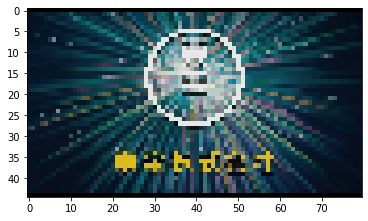

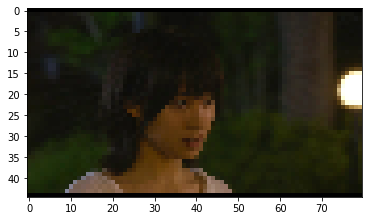

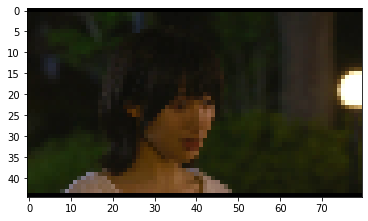

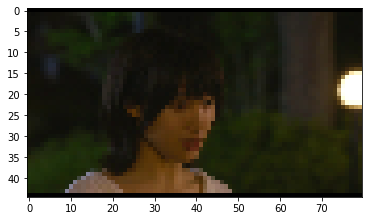

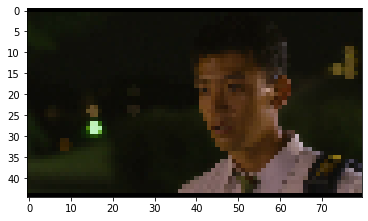

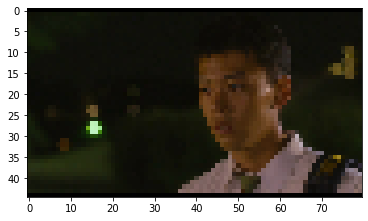

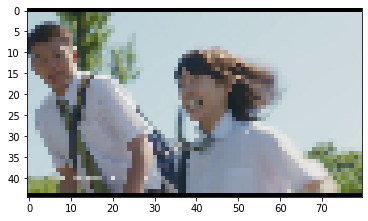

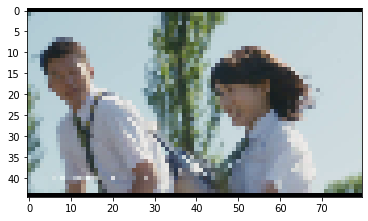

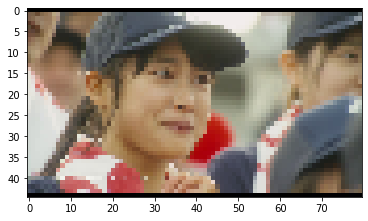

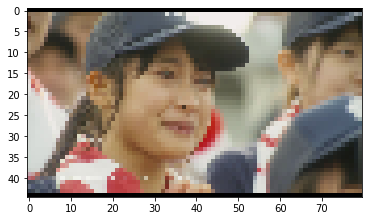

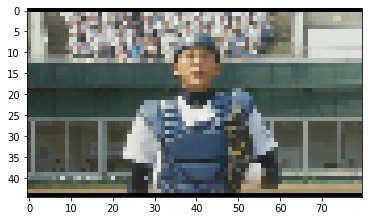

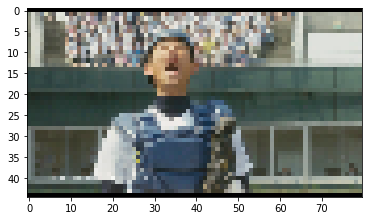

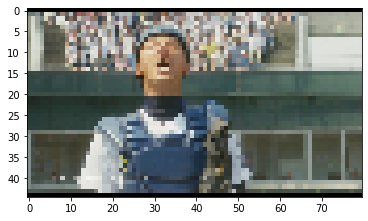

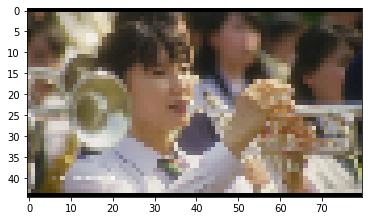

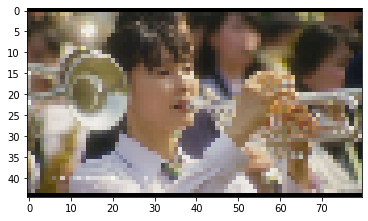

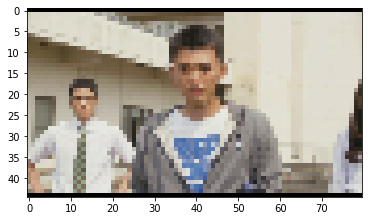

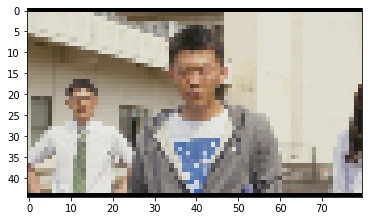

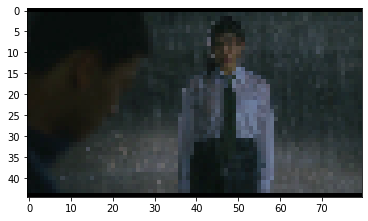

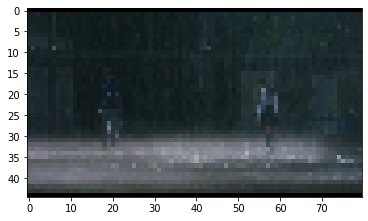

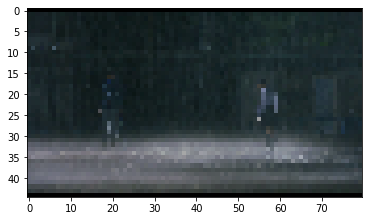

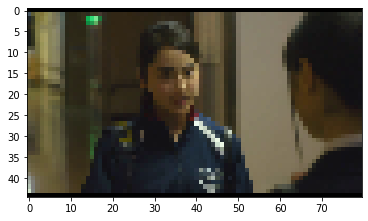

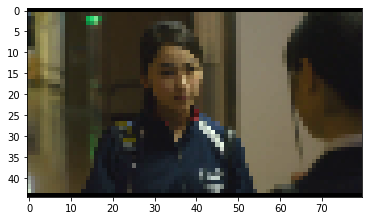

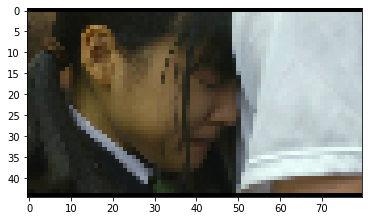

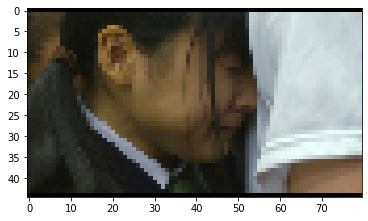

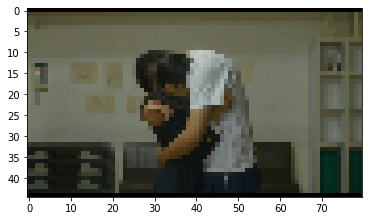

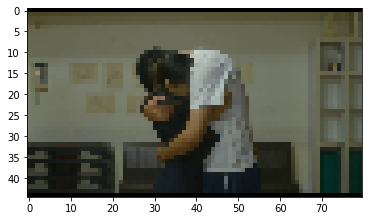

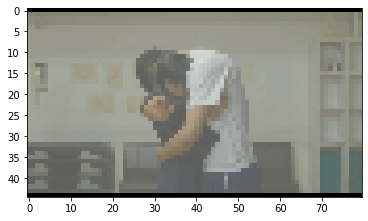

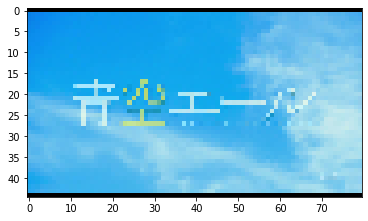

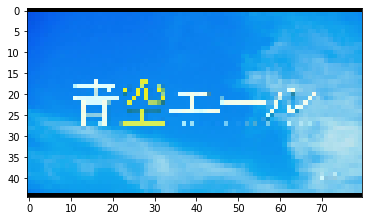

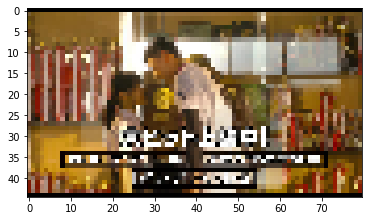

40


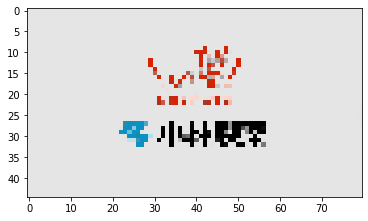

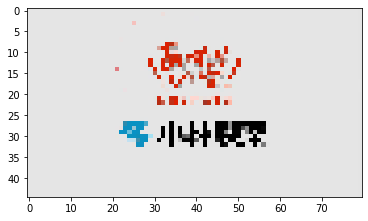

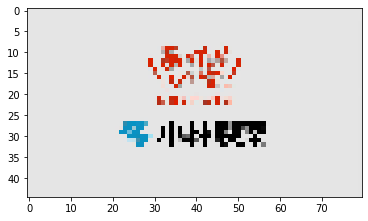

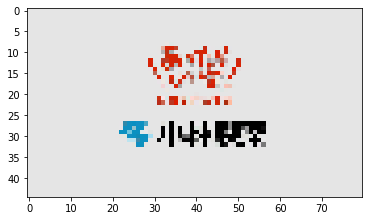

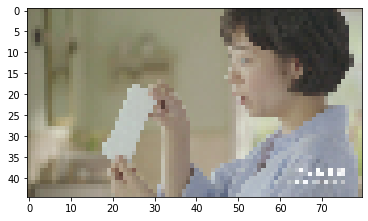

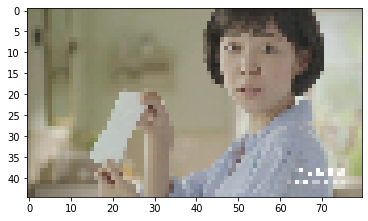

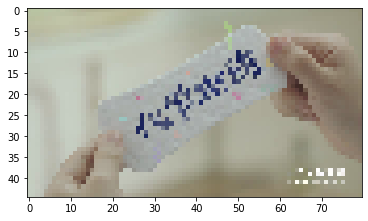

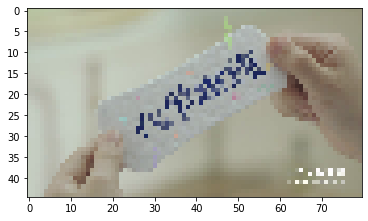

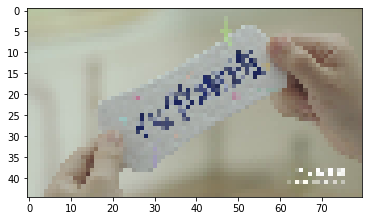

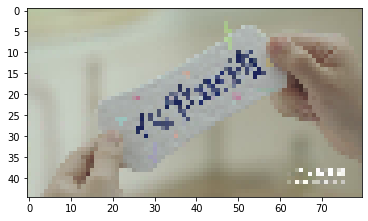

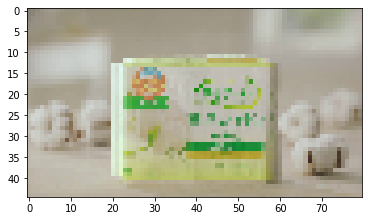

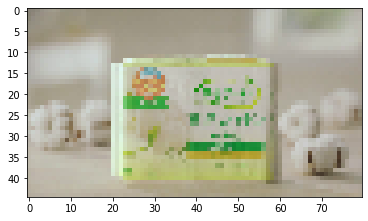

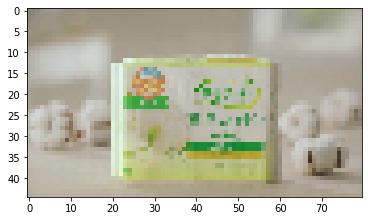

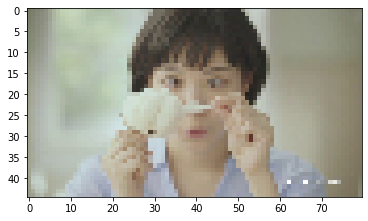

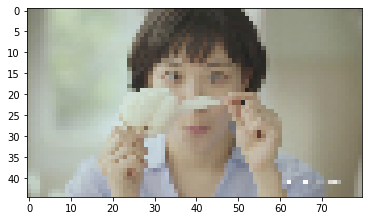

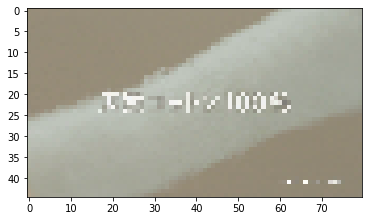

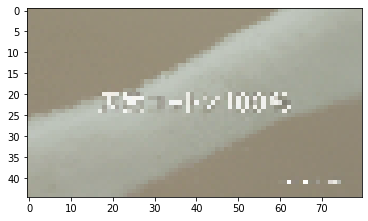

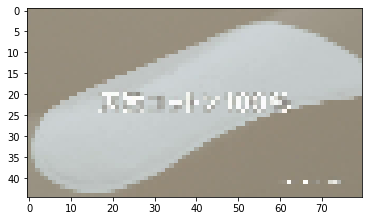

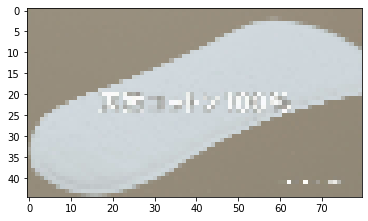

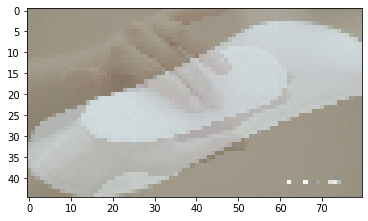

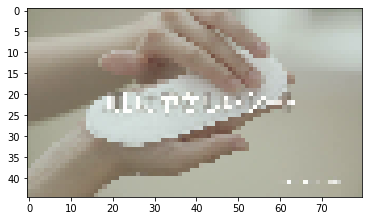

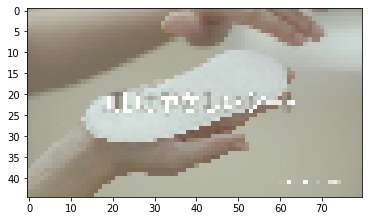

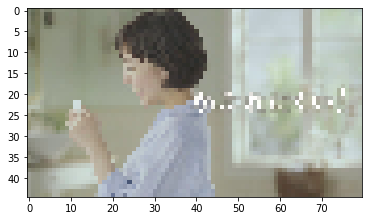

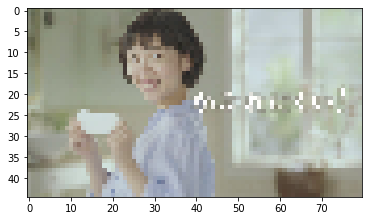

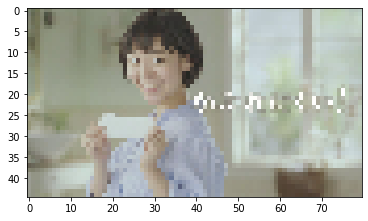

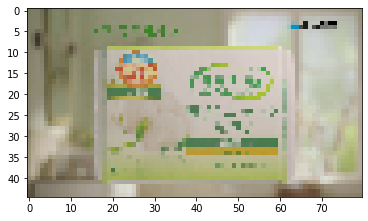

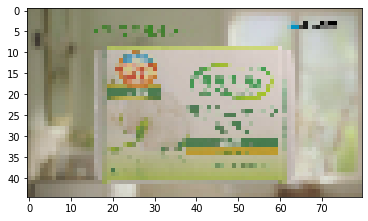

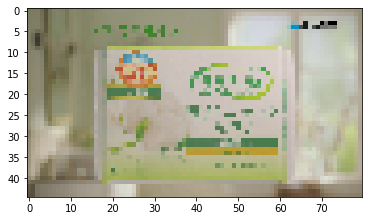

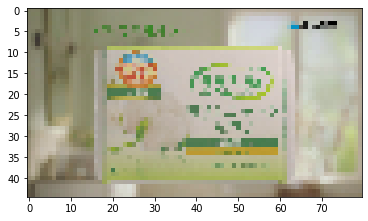

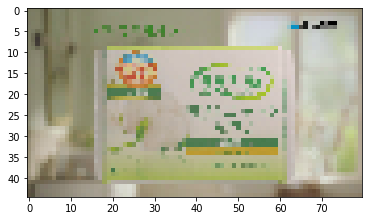

89


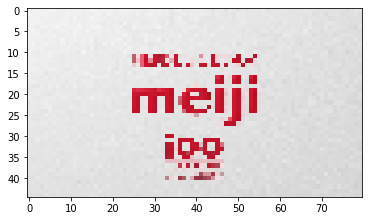

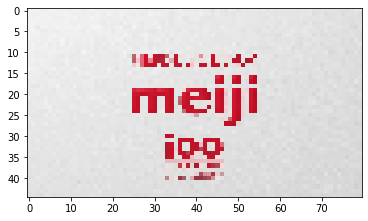

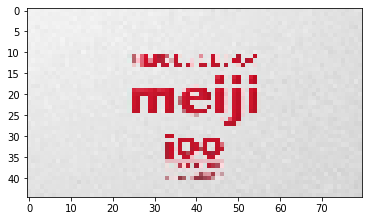

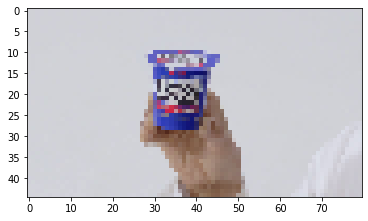

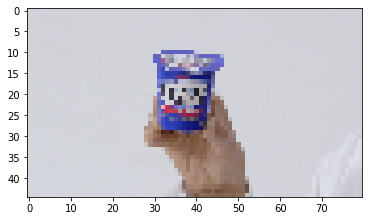

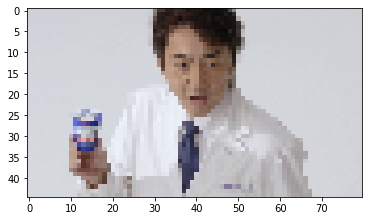

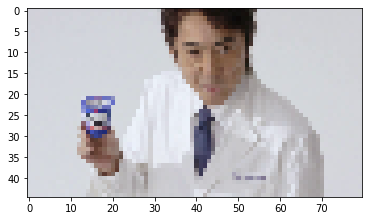

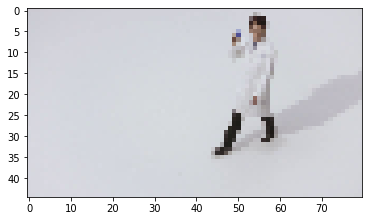

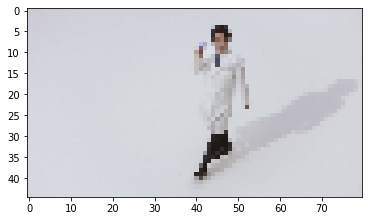

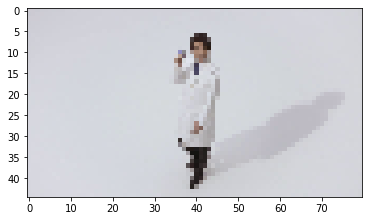

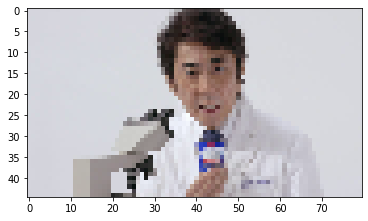

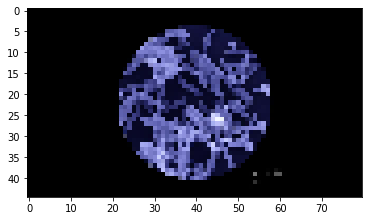

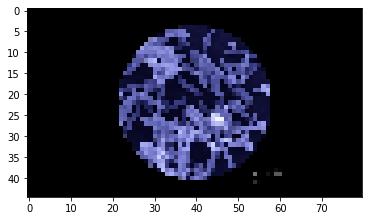

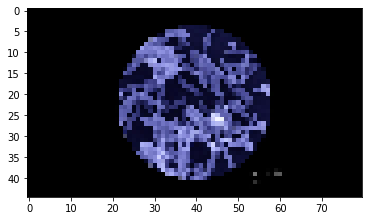

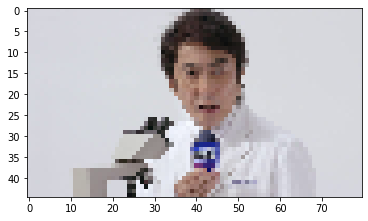

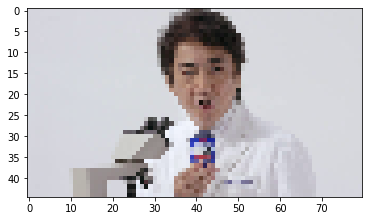

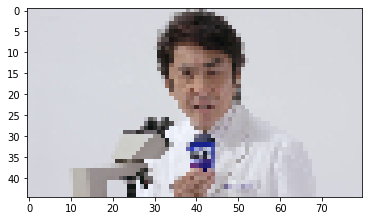

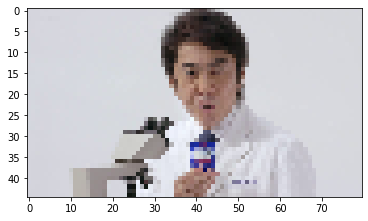

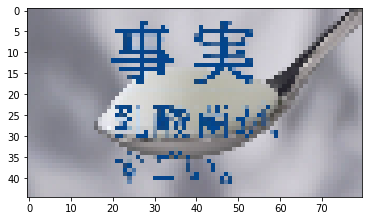

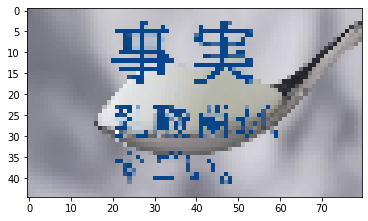

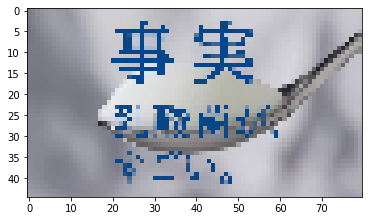

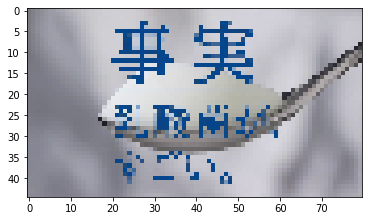

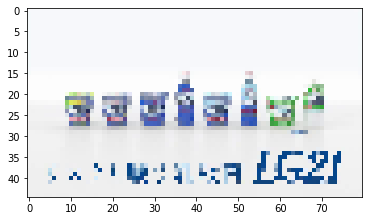

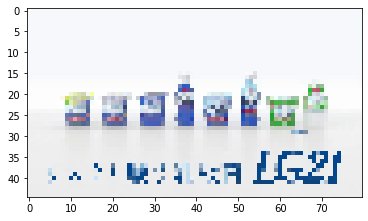

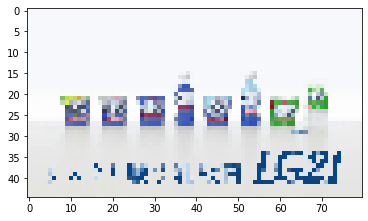

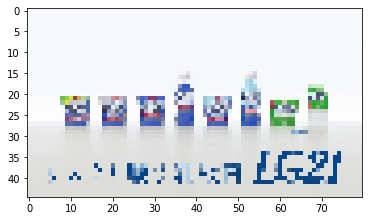

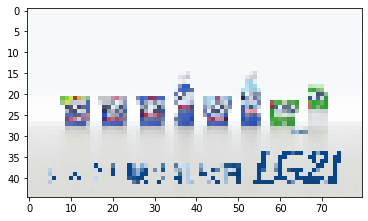

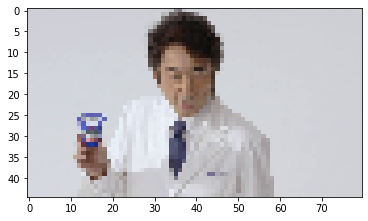

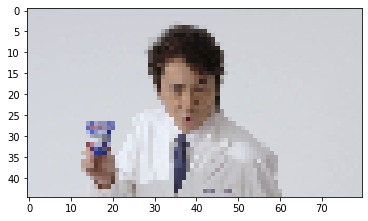

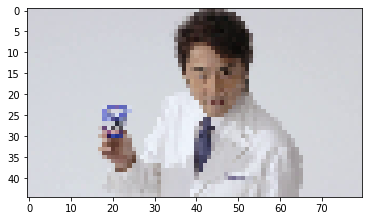

112


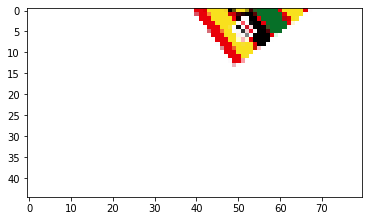

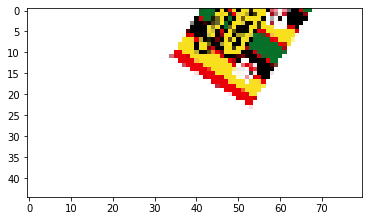

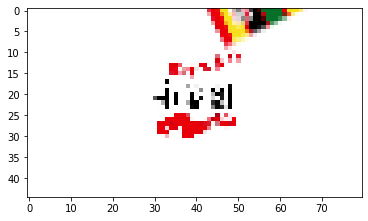

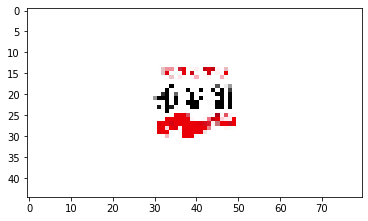

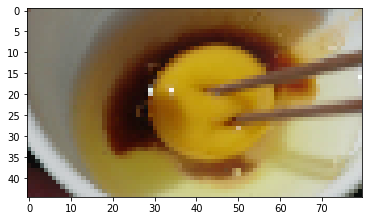

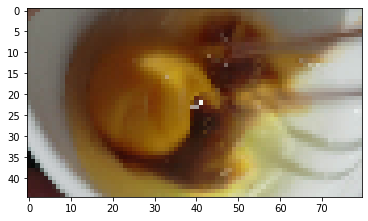

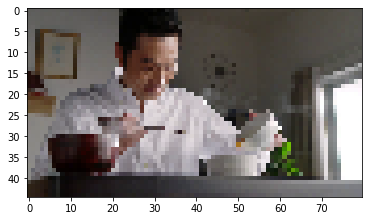

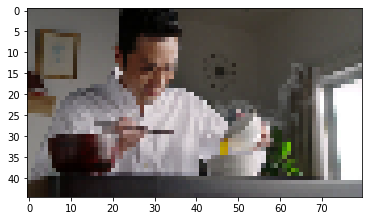

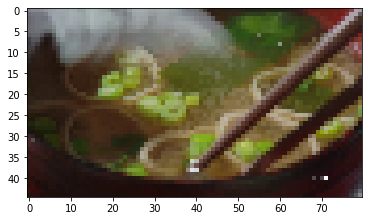

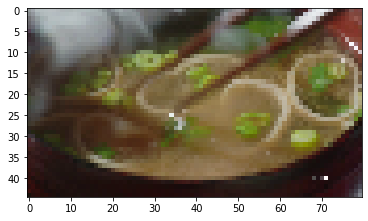

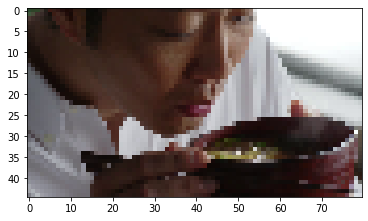

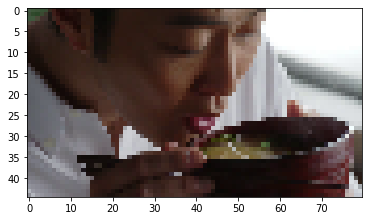

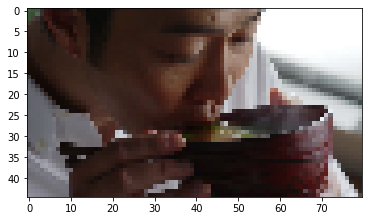

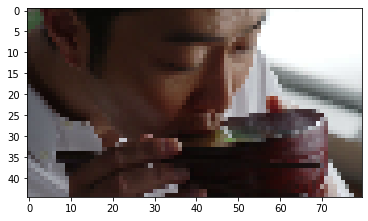

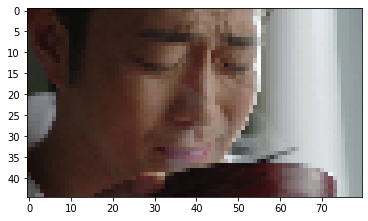

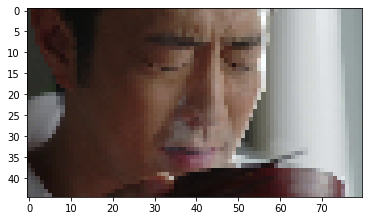

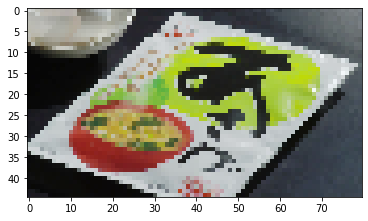

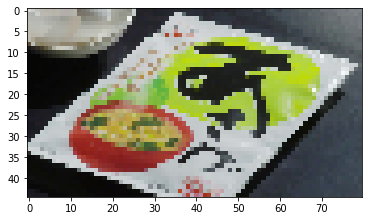

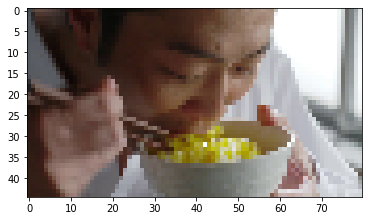

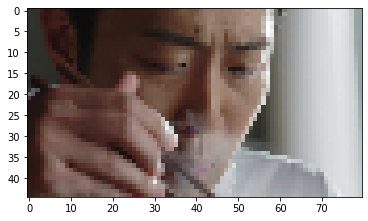

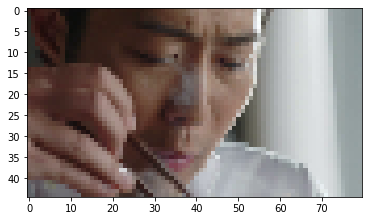

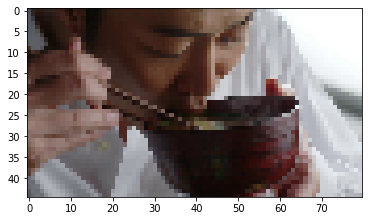

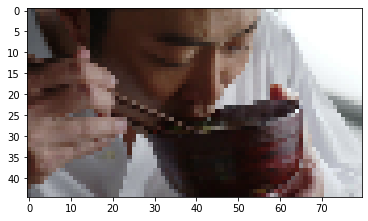

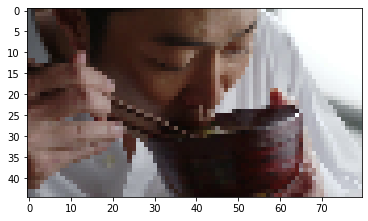

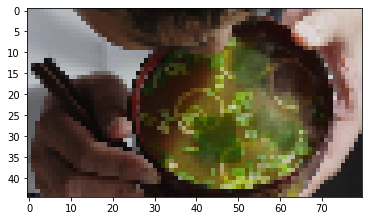

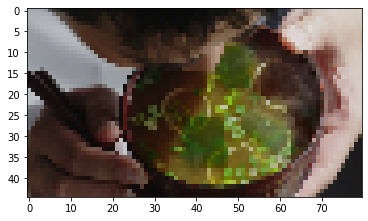

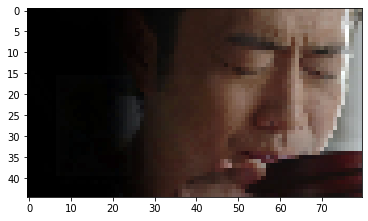

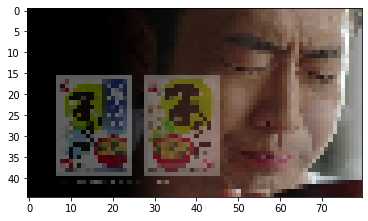

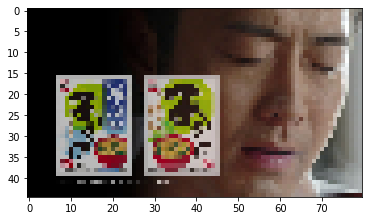

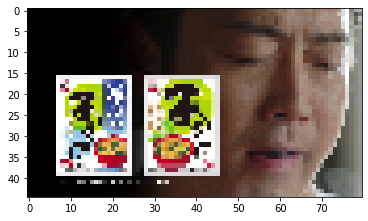

In [17]:
#@title 無作為抽出して確認
picks = [39, 40, 89, 112]

for pick in picks:
  sample = dwls[pick].data
  print(pick)
  for i in range(30):
    display_ndarray(sample[i])

In [18]:
#@title 整形データを保存
videos = []
labels = []
for dwl in dwls:
  videos.append(dwl.data)
  labels.append(dwl.label)
  
np.savez(os.path.join(desk, 'normalTrainVideos'), *videos)
np.savez(os.path.join(desk, 'normalTrainLabels'), *labels)

試しに読み込んでみる

In [20]:
v = np.load('/content/desk/normalTrainVideos.npz')
oneVideo = v['arr_0']
display_ndarray(oneVideo[10])

# [A-3]モデルの作成

In [22]:
#@title 入力データの情報を規定
colorSet = {'BW' : 1, 'RGB' : 3}

#入力層の設定
input_frameWIDTH = format1.WIDTH
input_frameHEIGHT = format1.HEIGHT
input_frameSIZE = format1.FRAME_SIZE
input_frameCOLOR = colorSet['RGB']
input_allPattern = input_frameWIDTH * input_frameHEIGHT * input_frameSIZE * input_frameCOLOR

print(
    input_frameWIDTH,
    input_frameHEIGHT,
    input_frameSIZE,
    input_frameCOLOR,
    input_allPattern )

80 45 30 3 324000


In [23]:
#@title モデルの作成
from tensorflow.keras import layers, models, initializers, callbacks
import tensorflow as tf
import numpy as np

seedKey = 20201218

np.random.seed(seedKey)
tf.random.set_seed(seedKey)

model = models.Sequential([
    # 入力層        
    layers.Reshape(
        (input_frameSIZE, input_frameHEIGHT, input_frameWIDTH,  input_frameCOLOR), 
        input_shape=(input_allPattern,),
        name='ENTRANCE' ),
    # 中間層
    layers.Flatten(
        name='RIVER' ),
    layers.Dense(
      1024, # 1024項
      activation='relu',
      name='DAM' ),
    # 出力層
    layers.Dense(4, activation='softmax', name='WATERSUPPLY')
])

name_model = 'key' + str(seedKey)
name_model = name_model + '.h5'
path_model = os.path.join('/content/desk/', name_model)
model.save(path_model)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ENTRANCE (Reshape)           (None, 30, 45, 80, 3)     0         
_________________________________________________________________
RIVER (Flatten)              (None, 324000)            0         
_________________________________________________________________
DAM (Dense)                  (None, 1024)              331777024 
_________________________________________________________________
WATERSUPPLY (Dense)          (None, 4)                 4100      
Total params: 331,781,124
Trainable params: 331,781,124
Non-trainable params: 0
_________________________________________________________________


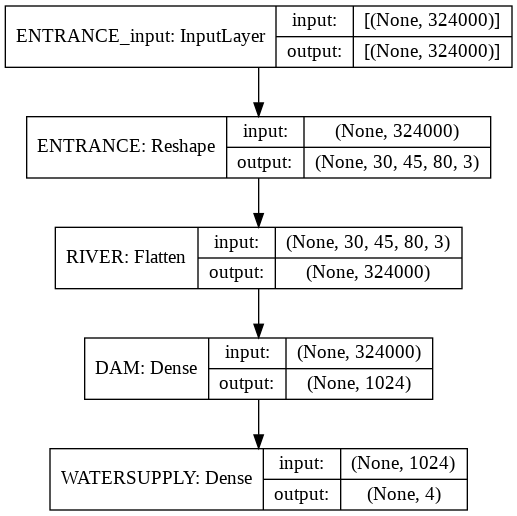

In [24]:
#表示
model.summary()
from tensorflow.keras.utils import plot_model
plot_model(
  model,
  show_shapes=True,
  )

In [25]:
del model
import gc
gc.collect()

2917

# [A-4]学習

In [26]:
#@title データ用意
import numpy as np

v = np.load('/content/desk/normalTrainVideos.npz')
l = np.load('/content/desk/normalTrainLabels.npz')

In [39]:
train_videos = []
train_labels = []
for i in v.files:
  train_videos.append(v[i])
for i in l.files:
  train_labels.append(l[i])

train_videos = np.array(train_videos)
train_labels = np.array(train_labels)

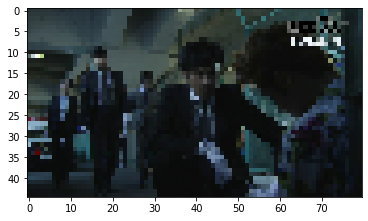

In [45]:
sample = train_videos[4]
image1 = sample[1]
display_ndarray(image1)

In [52]:
# データを一列にする
train_videos = train_videos.reshape(len(train_videos), input_allPattern).astype('float32')/255
train_labels = tf.keras.utils.to_categorical(labels, 4)
print(train_videos.shape)

(129, 324000)

In [48]:
#@title モデル用意
model = models.load_model('/content/desk/key20201218.h5')
model.summary()
from tensorflow.keras.utils import plot_model
plot_model(
  model,
  show_shapes=True,
  )

## 学習

In [350]:
# def inverse_dict(d):
#     return {v:k for k,v in d.items()}

# losses = {
#     'CEE' : 'categorical_crossentropy',
#     'MSE' : 'mean_squared_error',
#     'MSLE' : 'mean_squared_logarithmic_error',
#     'MAE' : 'mean_absolute_error',
# }
# inv_losses = inverse_dict(losses)

In [54]:
model.compile(optimizer='adam', 
                loss = 'categorical_crossentropy',
                metrics=['acc'])

history = model.fit(
      train_videos, 
      train_labels, 
      batch_size=8,
      epochs=64
      )

Epoch 1/64
17/17 [==============================] - 3s 72ms/step - loss: 459.2923 - acc: 0.3104
Epoch 2/64
17/17 [==============================] - 1s 71ms/step - loss: 133.5511 - acc: 0.3824
Epoch 3/64
17/17 [==============================] - 1s 72ms/step - loss: 116.2279 - acc: 0.4181
Epoch 4/64
17/17 [==============================] - 1s 71ms/step - loss: 74.6164 - acc: 0.4851
Epoch 5/64
17/17 [==============================] - 1s 72ms/step - loss: 24.0280 - acc: 0.7303
Epoch 6/64
17/17 [==============================] - 1s 71ms/step - loss: 15.7380 - acc: 0.7150
Epoch 7/64
17/17 [==============================] - 1s 72ms/step - loss: 9.2393 - acc: 0.7651
Epoch 8/64
17/17 [==============================] - 1s 72ms/step - loss: 18.8112 - acc: 0.7187
Epoch 9/64
17/17 [==============================] - 1s 71ms/step - loss: 0.9727 - acc: 0.9689
Epoch 10/64
17/17 [==============================] - 1s 73ms/step - loss: 13.6266 - acc: 0.8117
Epoch 11/64
17/17 [=============================

# [A-5]学習の評価

In [57]:
from pandas import DataFrame
def plotAcc(history):
  fig = plt.figure()
  ACC = fig.add_subplot(1,1,1)
  props = {
      'title' : 'plot of ACCURACY',
      'xlabel' : 'epoch',
      'ylabel' : 'value'
  }
  ACC.set(**props)
  acc = DataFrame(history.history['acc'])
  ACC.plot(acc, label='acc', marker='o', color='blue')
  ACC.legend()

def plotLoss(history):
  fig = plt.figure()
  LOSS = fig.add_subplot(1,1,1)
  props = {
      'title' : 'plot of LOSS',
      'xlabel' : 'epoch',
      'ylabel' : 'value'
  }
  LOSS.set(**props)
  loss = DataFrame(history.history['loss'])
  LOSS.plot(loss, label='loss', marker='o', color='blue')
  LOSS.legend()

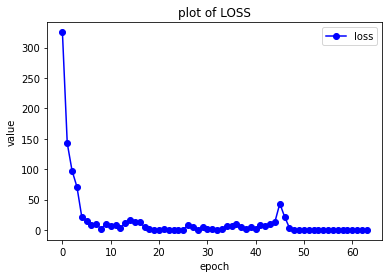

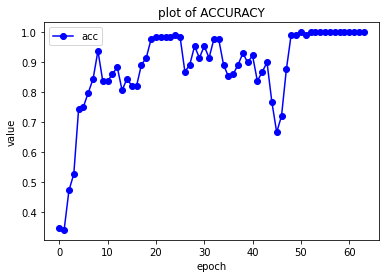

In [59]:
#@title accuracy, loss 描画
plotLoss(history)
plotAcc(history)

#ストレージへ保存

In [60]:
shelf = '/content/drive/MyDrive/colab'
book = 'dence1223'
shelf_book = os.path.join(shelf, book)
if not os.path.exists(shelf_book):
  os.mkdir(shelf_book)

In [61]:
wants_paths = [
         '/content/desk/key20201218.h5',
         '/content/desk/normalTrainLabels.npz',
         '/content/desk/normalTrainVideos.npz'
]

In [63]:
import shutil
for want in wants_paths:
  shutil.copy2(
      want,
      shelf_book
  )
              